# Music Recommendation With PyG
This Notebook demonstrates how to implement music recommendation using PyG on Spotify's Million Playlist Dataset

## Install Dependencies

In [3]:
! pip -q install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 27.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
! pip -q install torch
! pip -q install torch_sparse
! pip -q install torch_scatter
! pip -q install pandas
! pip -q install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 KB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 KB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


 # Download Data 
 Because the MPD is so large we will only download the preprocessed version of the dataset. To see how the dataset was created check out our github repo. 
https://github.com/jacobDeutsch10/cs224w-final-project

In [5]:
! wget https://raw.githubusercontent.com/jacobDeutsch10/cs224w-final-project/main/data/sample_graph.csv

--2023-03-21 20:42:27--  https://raw.githubusercontent.com/jacobDeutsch10/cs224w-final-project/main/data/sample_graph.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11616481 (11M) [text/plain]
Saving to: ‘sample_graph.csv.1’

sample_graph.csv.1  100%[===================>]  11.08M  --.-KB/s    in 0.03s   

2023-03-21 20:42:27 (358 MB/s) - ‘sample_graph.csv.1’ saved [11616481/11616481]



# Imports

In [6]:
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import LightGCN
from torch_geometric.utils import degree
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt


# Data Preprocessing
Here we read in the dataset and do some simple preprocessing steps. The data is stored as an edge index in a csv file. Each playlist and song has a unique identifier. Songs are numbered from 2,000,000 to 4,000,000 and playlists are numbered from 0 to 1,000,000.

First we sort the edges from the csv file so that the first column correspond to playlist nodes. Then we take the count of unique ids in the first and second columns to find the number of playlists and tracks respectibely. Then we reindex the songs and playlists so their ids are continuous from 0 to num_playlist+num_tracks. This needs to be done because playlist and track ids will be used by LightGCN to index into the dense embedding tensor during training/evaluation. 

In [7]:
# Read in our graph, the third column is an empty edge attribute column so we can drop it
df = pd.read_csv('sample_graph.csv', header=None, delimiter=" ").to_numpy()[:,:2]

# remove mirrored edges for now these will be filled back in by RandomLink Split
df = df[df[:,0] < 2000000]

# count the number of unique playlists and tracks
num_playlists = len(np.unique(df[:, 0]))
num_tracks = len(np.unique(df[:, 1]))

# currently our node ids need to be reindexed so they are continuous:
old_id_to_new_id_playlist = dict(zip(np.unique(df[:, 0]), range(num_playlists)))
old_id_to_new_id_track = dict(zip(np.unique(df[:, 1]), range(num_playlists, num_playlists + num_tracks)))
old_id_to_new_id_playlist, old_id_to_new_id_track
df[:, 0] = [old_id_to_new_id_playlist[i] for i in df[:, 0]]
df[:, 1] = [old_id_to_new_id_track[i] for i in df[:, 1]]

# transposing to put it into the pyg edge_index format ([2, num edges])
df = df.T.astype(int)

In [8]:
print(f'number of tracks: {num_tracks}, number of playlists: {num_playlists}')

number of tracks: 7955, number of playlists: 10938


In [9]:
#### THIS CODE WAS COPIED FROM https://colab.research.google.com/drive/1EdgZaTb8mtc4vEnedNNtRygZ_Ls-jQqy?usp=sharing  ####
# credit to this team for figuring out how to set up this dataset
class PlainData(Data):
    """
    Custom Data class for use in PyG. Basically the same as the original Data class from PyG, but
    overrides the __inc__ method because otherwise the DataLoader was incrementing indices unnecessarily.
    Now it functions more like the original DataLoader from PyTorch itself.
    See here for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html
    """
    def __inc__(self, key, value, *args, **kwargs):
        return 0

class SpotifyDataset(Dataset):
    """
    Dataset object containing the Spotify supervision/evaluation edges. This will be used by the DataLoader to load
    batches of edges to calculate loss or evaluation metrics on. Here, get(idx) will return ALL outgoing edges of the graph
    corresponding to playlist "idx." This is because when calculating metrics such as recall@k, we need all of the
    playlist's positive edges in the same batch.
    """
    def __init__(self, root, edge_index, transform=None, pre_transform=None):
        self.edge_index = edge_index
        self.unique_idxs = torch.unique(edge_index[0,:]).tolist() # playlists will all be in row 0, b/c sorted by RandLinkSplit
        self.num_nodes = len(self.unique_idxs)
        super().__init__(root, transform, pre_transform)

    def len(self):
        return self.num_nodes

    def get(self, idx): # returns all outgoing edges associated with playlist idx
        edge_index = self.edge_index[:, self.edge_index[0,:] == idx]
        return PlainData(edge_index=edge_index)

Here we convert our edge index into a PyG Data object. This will be necessary for implement other PyG functionality later on.

In [10]:
num_nodes = num_playlists + num_tracks
data = Data(edge_index=torch.tensor(df, dtype=torch.int64), num_nodes=num_nodes)

# Split Data

Here we use PyG's RandomLinkSplit to split our data into a train, validation, and test set. We do this because we do not want to evaluate our model on edges that were used in training as this would skew our results.

In [11]:
train_data, val_data, test_data =\
        RandomLinkSplit(num_val=0.15, num_test=0.15, add_negative_train_samples=False, is_undirected=True)(data)

# Setup Datasets

In [12]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
val_data = val_data.to(device)
test_data = test_data.to(device)
train_data = train_data.to(device)
data = data.to(device)
# Shoutout to other group for figuring out how to do this
train_dataset = SpotifyDataset(root='.', edge_index=train_data.edge_label_index)
val_dataset = SpotifyDataset(root='.', edge_index=val_data.edge_label_index)
test_dataset = SpotifyDataset(root='.', edge_index=test_data.edge_label_index)

train_data, val_data, test_data

(Data(edge_index=[2, 404570], num_nodes=18893, edge_label=[202285], edge_label_index=[2, 202285]),
 Data(edge_index=[2, 404570], num_nodes=18893, edge_label=[86692], edge_label_index=[2, 86692]),
 Data(edge_index=[2, 491262], num_nodes=18893, edge_label=[86692], edge_label_index=[2, 86692]))

# Evaluation Metrics
In order to evaluate the success of the learned model, we use Recall@K and Precision@K. These metrics compare the number of song recommendations made by the learned model and the number of relevant items. Precision@K measures how often songs that are recommended are relevant. So, given all the recommended songs from the learned model, it measures how many songs were actually listed in the playlist. Recall@K measures how often songs that are relevant are recommended. So, given the relevant songs, it measures how many of them are recommended from the learned model. The equations for Precision@K and Recall@K are shown in equations below.

\begin{equation}
    P@K = \frac{\text{# of top-k recommendations that are relevant}}{\text{# of top-k recommendations}}
\end{equation}

\begin{equation}
    R@K =\frac{\text{# of top-k recommendations that are relevant}}{\text{# of songs that are relevant}}
\end{equation}

In [13]:
def recall_precision_at_k(model, edge_index, edge_label_index, k):
    """Calculates the recall and precision at k for a given model.

    Args:
        model (LightGCN): The model to evaluate.
        edge_index (Tensor): Edge index of the graph used for message passing.
        edge_label_index (Tensor): Edge index of the graph used for evaluation
        k (int): K for top-k evaluation.

    Returns:
        float: Recall at k.
        float: Precision at k.
    """
    # Get embeddings for all nodes in the graph
    out_src = out_dst = model.get_embedding(edge_index)
    # compute scores for each edges
    result = (out_src @ out_dst.t()).sigmoid()

    # filter out irrelevant edges and edges that are already known
    result[edge_index[0], edge_index[1]] = -100000000 # set known edges to low value
    result[edge_index[0], :num_playlists]= -100000000 # don't care about playlist-playlist edges

    # Compute the top k edges for each node
    topk = torch.topk(result, k=k, dim=-1).indices.detach().cpu().numpy()
    recall_sum = 0
    precision_sum = 0
    # loop over each node in the edge_label_index to compute recall and precision for that node
    for i in range(edge_label_index.shape[1]):
        user = edge_label_index[0][i].item()
        # find the positive items for the current user
        # Note how we are only looking in the edge_label_index 
        # this is because we only care about edges that were not used in message passing
        positive_items = edge_label_index[:,edge_label_index[0]==user][1].detach().cpu().numpy()
        # find the number of correct predicted edges
        num_correct = len(np.intersect1d(topk[user], positive_items))
        # recall is # number correct / # of positive items
        recall_sum +=  num_correct/len(positive_items) if len(positive_items) > 0 else 0
        # precision is # number correct / # of predictions
        precision_sum += num_correct/k
    return recall_sum/edge_label_index.shape[1], precision_sum/edge_label_index.shape[1]

# Negative Sampling
In order to train the model we need to be able to sample 'negative' edges. A negative edge is an edge that could exist but does not. The reason we do this is that we use the Bayesian Personalized Ranking (BPR) Loss to optimize our model. The BPR loss is a contrastive loss meaning it tries to maximize the probability of the model correctly predicting an unseen edge to a given query node while minimize the probability of the model incorrectly predicting an edge to the query node.

In [14]:
def sample_neg_edges(edge_index):
    """samples negative edges for a given edge_index

    Args:
        edge_index (Tensor): A tensor representing a single batch of positive edges

    Returns:
        Tensor: A tensor representing a single batch of negative edges
    """
    # We found sampling true negatives at each step to be too expensive
    # comparable performance can be achieved with pure random sampling because sampling a false negative is unlikely
    return torch.stack(
        [
            edge_index[0],
            torch.randint(num_playlists, num_nodes, (edge_index.shape[1],), dtype=torch.long).to(device)
        ], dim=0
    )

# Model Training
The function below trains our model for one epoch. There are a few important steps:  
1. Set model to training mode with `model.train()`
2. Load in a batch of data. Here a batch refers to a set of positive edges in our graph.
3. Negative Sampling: sample a negative edge for each positive edge in the batch
4. Compute scores for each positive and negative edge. The higher the score the more the model thinks the edge is a positive edge in the graph.
5. Compute the BPR loss for every positive and negative edge pair.
6. Compute gradients and perform backpropagation with `loss.backward()` and `optimizer.step()`

# LightGCN
LightGCN is a lightweight model specialized in collaborative filtering. It is lightweight because it contains no non-linear activations, and the only learnable-parameters are the layer-zero embeddings. The message passing function is the weighted average of each nodes neighbor embeddings at each step. The message passing function for node $e$ at layer $k$ is:
\begin{equation}
    {{e}_{u}}^{k+1}= \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}{{e}}_{i}^{k}
\end{equation}

More on the BPR Loss and LightGCN can be found in:
https://arxiv.org/abs/2002.02126

In [15]:
def train_one_epoch(
    model,
    dataloader,
    optimizer,
    scheduler,
    train_data,
    epoch
  ):
    """Trains the LightGCN model for one epoch.

    Args:
        model (LightGCN): LightGCN Model
        dataloader (DataLoader): Training dataloader
        optimizer (Optimizer): Optimizer used for training
        scheduler (Scheduler): Learning Rate Scheduler user for training
        train_data (Data): PyG Data object containing the training edges used in message passing
        epoch (int): current epoch

    Returns:
        list: list of losses for each batch
    """

    model.train()
    losses = []
    for idx, batch in enumerate(dataloader):
        optimizer.zero_grad()
        # Get positive and negative edges
        pos_edges = batch.edge_index.to(device)
        neg_edges = sample_neg_edges(pos_edges).to(device) # sample 1 negative edge for each positive edge
        mp_edges = train_data.edge_index.to(device)
        
        # compute scores for positive and negative edges
        pos_scores = model(mp_edges, pos_edges)
        neg_scores = model(mp_edges, neg_edges)
        
        # calculate BPR Loss
        loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores))
        # calculate loss and backprop
        loss.backward()
        optimizer.step()
        if idx % 10 == 0:
            print(f'Training, Epoch: {epoch+1}, Batch: {idx}/{len(dataloader)}, Loss: {loss}')
        losses.append(loss.item())
    scheduler.step()
    return losses

# Evaluation
Here we evaluate the model. This is very similar to training but with a few big differences. The steps are as follows:
1. Set model to evaluation mode with `model.eval()`
2. Load in a batch of data. Here a batch refers to a set of positive edges in our graph.
3. Negative Sampling: sample a negative edge for each positive edge in the batch
4. Compute scores for each positive and negative edge. The higher the score the more the model thinks the edge is a positive edge in the graph.
5. Compute the BPR loss for every positive and negative edge pair.
6. As we are validating our model do not compute gradients or backpropagate
7. Compute precision and recall at K. You might notice we compute these for the entire dataset rather than batch-by-batch. This is because we need to know all of the true-positive edges for each playlist that are not already in the graph in order to properly calculate precision and recall at K.

Note: We use 350 for the value at K. This means that for each playlist we compute 350 recommendations. This number was chosen as it corresponds to a model recommending 5% of the total songs in the dataset. 


In [16]:
def evaluate(
    model,
    dataloader,
    eval_data,
    epoch,
    K
):
    """Trains the LightGCN model for one epoch.

    Args:
        model (LightGCN): LightGCN Model
        dataloader (DataLoader): Validation dataloader
        train_data (Data): PyG Data object containing the validation edges used in message passing
        epoch (int): current epoch
        K (int): number of edges to consider for recall and precision
    Returns:
        list: list of losses for each batch
        float: recall@k
        float: precision@k
    """
    losses = []
    model.eval()
    for idx, batch in enumerate(dataloader):
        pos_edges = batch.edge_index
        neg_edges = sample_neg_edges(pos_edges)
        pos_scores = model(eval_data.edge_index, pos_edges)
        neg_scores = model(eval_data.edge_index, neg_edges)
        
        loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) 
        losses.append(loss.item())

    recall, precision = recall_precision_at_k(model, eval_data.edge_index, eval_data.edge_label_index, K)
    print(f'Validating, Epoch: {epoch+1}, Loss: {np.mean(losses)}, Recall: {recall}, Precision: {precision}')
    return losses, recall, precision

# Train and Evaluation Loop
Here is where we actually train the model and evaluate our model

In [17]:
def train_and_evaluate(
    model,
    optimizer,
    scheduler,
    train_data,
    val_data,
    test_data,
    train_dataloader,
    val_dataloader,
    test_dataloader,
    epochs,
    K
):
    """Trains and evaluates the LightGCN model for a given number of epochs. Returning metrics for each epoch."""
      
    train_loss_epochs = []
    val_loss_epochs = []
    val_recall_epochs = []
    val_prec_epochs = []
    for epoch in range(epochs):
        train_loss = train_one_epoch(
            model,
            train_dataloader,
            optimizer,
            scheduler,
            train_data,
            epoch
        )
        train_loss_epochs.append(np.mean(train_loss))
        print(f'Epoch {epoch + 1}/{epochs} Complete, Loss: {train_loss_epochs[-1]}')
        
        val_loss, val_recall, val_precision = evaluate(
          model,
          val_dataloader,
          val_data,
          epoch,
          K
        )
        val_loss_epochs.append(np.mean(val_loss))
        val_recall_epochs.append(val_recall)
        val_prec_epochs.append(val_precision)
    return train_loss_epochs, val_loss_epochs, val_recall_epochs, val_prec_epochs

This function reads in a dictionary of hyperparameters, builds the model, optimizers and LR scheduler, trains the models and reports training and evaluation statistics.

In [24]:
def build_and_train_model(
        hparams,
        train_data,
        val_data,
        test_data,
):
    """Builds and trains the LightGCN model.

      Args:
            hparams (dict): a dictionary containing the hyperparameters
            train_data (Data): PyG Data object containing the training edges used in message passing
            val_data (Data): PyG Data object containing the validation edges used in message passing
            test_data (Data): PyG Data object containing the test edges used in message passing

      Returns:
            LightGCN: trained LightGCN model
            list: list of validation recalls for each epoch
            list: list of validation precisions for each epoch
    """
    # read hyperparameters
    epochs = hparams.get('epochs', 20)
    LR_DECAY_EPOCHS = hparams.get('lr_decay_epochs', [15, 17])
    LR_DECAY_FACTOR = hparams.get('lr_decay_factor', 0.2)
    K = hparams.get('k', 350)
    lr = hparams.get('lr', 0.005)
    weight_decay = hparams.get('weight_decay', 0.0)
    embedding_dim = hparams.get('embedding_dim', 64)
    num_layers = hparams.get('num_layers', 3)
    batch_size = hparams.get('batch_size', 1024)
    # create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # create model
    model = LightGCN(
        num_layers=num_layers,
        num_nodes=num_nodes,
        embedding_dim=embedding_dim,
        use_cuda=True,
    )
    # We found that overriding pyg's default xavier initialization with a normal initialization worked better for our specific application
    torch.nn.init.normal_(model.embedding.weight)
    model.to(device)

    # create optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=LR_DECAY_EPOCHS, gamma=LR_DECAY_FACTOR)
    # train and evaluate the model
    (train_loss_epochs, val_loss_epochs, val_recall_epochs, val_prec_epochs) =\
          train_and_evaluate(
                model,
                optimizer,
                scheduler,
                train_data,
                val_data,
                test_data,
                train_loader,
                val_loader,
                test_loader,
                epochs,
                K
          )
    # Plot the results
    plt.plot(range(epochs), train_loss_epochs, label="Train Loss")
    plt.plot(range(epochs), val_loss_epochs, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Val Loss v.s. Epoch")
    plt.legend()
    plt.show()
    plt.plot(range(epochs), val_recall_epochs, label="Val Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.title("Val Recall v.s. Epoch")
    plt.legend()
    plt.show()
    plt.plot(range(epochs), val_prec_epochs, label="Val Precision")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.title("Val Precision v.s. Epoch")
    plt.legend()
    plt.show()

    return model, val_recall_epochs, val_prec_epochs

# Let's train a LightGCN!
Here we train a LightGCN on our dataset.
The hyperparameters in the hparams dict are as follows:
1. Epochs: the number of epochs to train the model. Here it's 20 meaning we are taking 20 passes over our training dataset
2. lr_decay_epochs: these are the epochs at which we decay our learning rate. Decaying the learning rate can help the model converge and improve performance on the val/test set
3. lr_decay_factor: the multiplicative factor we decay the learning rate by.
4. K: this is the K we use to evaluate recall@K and precision@K
5. lr: the initial learning rate used to train the model
6. weight_decay: this is an optional parameter used by the Adam optimizer. It applies L2-regularization to the parameters of the model
7. embedding_dim: the dimensionality of the learned node embeddings
8. num_layers: the number of layers of message-passing used in LightGCN
9. batch_size: the batchsize used to train the model.


/usr/local/lib/python3.9/dist-packages/torch_geometric/data/storage.py:280: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Training, Epoch: 1, Batch: 0/11, Loss: -0.9896036386489868
Training, Epoch: 1, Batch: 10/11, Loss: -1.017781138420105
Epoch 1/20 Complete, Loss: -1.0002008893273093
Validating, Epoch: 1, Loss: -0.7796021898587545, Recall: 0.03585105892123639, Precision: 0.0009984444107545235
Training, Epoch: 2, Batch: 0/11, Loss: -1.035886526107788
Training, Epoch: 2, Batch: 10/11, Loss: -1.0770606994628906
Epoch 2/20 Complete, Loss: -1.0503701946952126
Validating, Epoch: 2, Loss: -0.7945220635996925, Recall: 0.04239145480551594, Precision: 0.001230101970193082
Training, Epoch: 3, Batch: 0/11, Loss: -1.0981945991516113
Training, Epoch: 3, Batch: 10/11, Loss: -1.1596070528030396
Epoch 3/20 Complete, Loss: -1.120363170450384
Validating, Epoch: 3, Loss: -0.8206789195537567, Recall: 0.05404189544594375, Precision: 0.001659207308632905
Training, Epoch: 4, Batch: 0/11, Loss: -1.17057204246521
Training, Epoch: 4, Batch: 10/11, Loss: -1.3192318677902222
Epoch 4/20 Complete, Loss: -1.2308434356342663
Validating

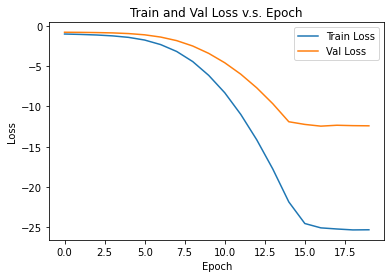

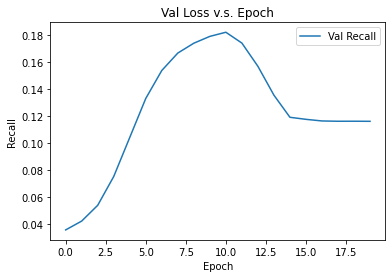

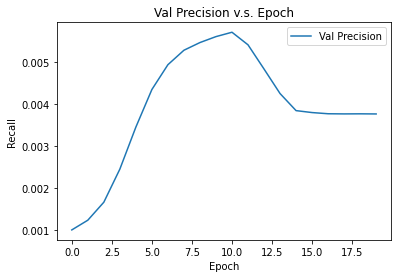

Best Val Recall: 0.18194297051632952 at epoch 10


In [19]:

hparams = {
    'epochs': 20,
    'lr_decay_epochs': [15, 17],
    'lr_decay_factor': 0.1,
    'k': 350,
    'lr': 0.005,
    'weight_decay': 0.0,
    'embedding_dim': 64,
    'num_layers': 3,
    'batch_size': 1024
}
model, val_recall_epochs, val_prec_epochs = build_and_train_model(
    hparams,
    train_data,
    val_data,
    test_data,
)
best_recall = max(val_recall_epochs)
print(f'Best Val Recall: {best_recall} at epoch {val_recall_epochs.index(best_recall)}')


# Results
We achieved our best recall@350 at epoch 10 with a recall@350 of 0.182. This means that on average 18.2% of the recommended songs were songs actually contained within the holdout set of a given playlist!


`Best Val Recall: 0.18194297051632952 at epoch 10`

# Evaluation on the test set


In [20]:
# calculate precision and recall on test set
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
test_loss, test_recall, test_precision = evaluate(
    model,
    test_loader,
    test_data,
    0,
    K=350,
)
print(f'Test Recall: {test_recall}, Test Precision: {test_precision}')

Validating, Epoch: 1, Loss: -12.288547171486748, Recall: 0.11810778387856363, Precision: 0.003762284870575623
Test Recall: 0.11810778387856363, Test Precision: 0.003762284870575623


# Hyperparameter search

In [25]:

def run_hparam_search(all_hparams, train_data, val_data, test_data):
    """Runs a hyperparameter search over a list of hyperparameters.

    Args:
        all_hparams (list(dict)): a list of dicts containing hyperparameters
        train_data (Data): training data
        val_data (Data): validation data
        test_data (Data): test data

    Returns:
        LightGCN: the best model
        dict: the best hyperparameters
        float: the best recall
    """
    best_recall = 0
    best_recall_epoch = None
    best_hparams = None
    best_model = None
    for hparams in all_hparams:
        model, val_recall_epochs, val_prec_epochs = build_and_train_model(
            hparams,
            train_data,
            val_data,
            test_data,
        )
        recall = max(val_recall_epochs)
        if recall > best_recall:
            best_recall = recall
            best_hparams = hparams
            best_model = model
            best_recall_epoch = val_recall_epochs.index(recall)
    return best_model, best_hparams, best_recall, best_recall_epoch

In [26]:
all_hparams = [
    {
    'embedding_dim': 32,
    'num_layers': 3,
    'batch_size': 1024
    },
    {
    'embedding_dim': 64,
    'num_layers': 3,
    'batch_size': 2048
    },
    {
    'embedding_dim': 64,
    'num_layers': 2,
    'batch_size': 1024
    },
    {
    'embedding_dim': 64,
    'num_layers': 3,
    'batch_size': 2048
    },
]

Training, Epoch: 1, Batch: 0/11, Loss: -0.8383763432502747
Training, Epoch: 1, Batch: 10/11, Loss: -0.8515706062316895
Epoch 1/20 Complete, Loss: -0.8395540497519753
Validating, Epoch: 1, Loss: -0.7402459449238248, Recall: 0.03515895353665704, Precision: 0.0009955441596191386
Training, Epoch: 2, Batch: 0/11, Loss: -0.8501659035682678
Training, Epoch: 2, Batch: 10/11, Loss: -0.8844099640846252
Epoch 2/20 Complete, Loss: -0.8659762794321234
Validating, Epoch: 2, Loss: -0.7471015519566007, Recall: 0.0393692612928513, Precision: 0.0011419079697580665
Training, Epoch: 3, Batch: 0/11, Loss: -0.8806795477867126
Training, Epoch: 3, Batch: 10/11, Loss: -0.9183182120323181
Epoch 3/20 Complete, Loss: -0.8976203094829213
Validating, Epoch: 3, Loss: -0.7580456866158379, Recall: 0.04675171872836997, Precision: 0.0014027657849460774
Training, Epoch: 4, Batch: 0/11, Loss: -0.9223375916481018
Training, Epoch: 4, Batch: 10/11, Loss: -0.9818814992904663
Epoch 4/20 Complete, Loss: -0.9478348276831887
Vali

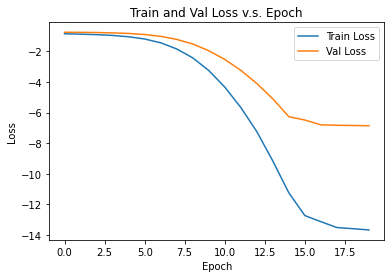

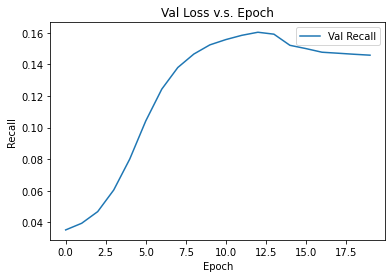

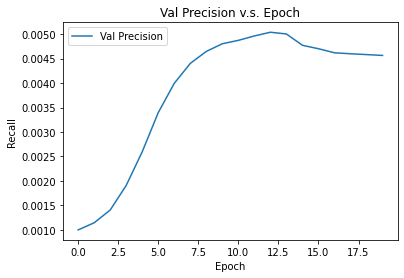

Training, Epoch: 1, Batch: 0/6, Loss: -0.9818283319473267
Epoch 1/20 Complete, Loss: -0.9853360255559286
Validating, Epoch: 1, Loss: -0.7816279133160909, Recall: 0.03579338347252184, Precision: 0.0009833169644915731
Training, Epoch: 2, Batch: 0/6, Loss: -1.0104576349258423
Epoch 2/20 Complete, Loss: -1.0197863976160686
Validating, Epoch: 2, Loss: -0.7871036661995782, Recall: 0.03827342776726627, Precision: 0.0010719064537177408
Training, Epoch: 3, Batch: 0/6, Loss: -1.034437894821167
Epoch 3/20 Complete, Loss: -1.0539325873057048
Validating, Epoch: 3, Loss: -0.8001639975441827, Recall: 0.04218382319014214, Precision: 0.0012141505889484874
Training, Epoch: 4, Batch: 0/6, Loss: -1.0634725093841553
Epoch 4/20 Complete, Loss: -1.0928424994150798
Validating, Epoch: 4, Loss: -0.8087303108639188, Recall: 0.047732201356524395, Precision: 0.0014208923545422107
Training, Epoch: 5, Batch: 0/6, Loss: -1.1187925338745117
Epoch 5/20 Complete, Loss: -1.1456009944279988
Validating, Epoch: 5, Loss: -0.

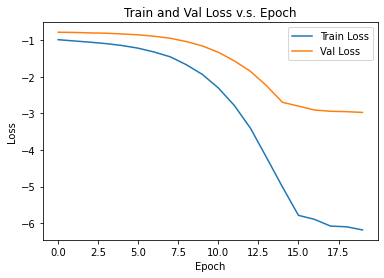

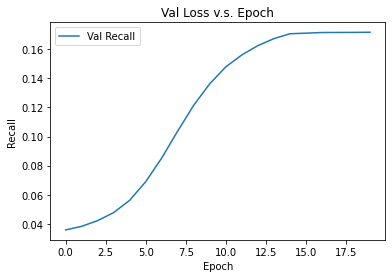

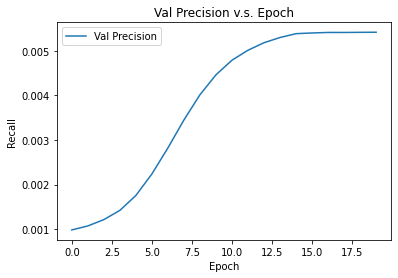

Training, Epoch: 1, Batch: 0/11, Loss: -1.2480682134628296
Training, Epoch: 1, Batch: 10/11, Loss: -1.2990586757659912
Epoch 1/20 Complete, Loss: -1.2640312043103306
Validating, Epoch: 1, Loss: -0.921323385503557, Recall: 0.034259216536703066, Precision: 0.0009486457804640874
Training, Epoch: 2, Batch: 0/11, Loss: -1.3074615001678467
Training, Epoch: 2, Batch: 10/11, Loss: -1.3667562007904053
Epoch 2/20 Complete, Loss: -1.3314300992272117
Validating, Epoch: 2, Loss: -0.9351371129353842, Recall: 0.036208646703269634, Precision: 0.001016439150753581
Training, Epoch: 3, Batch: 0/11, Loss: -1.3636575937271118
Training, Epoch: 3, Batch: 10/11, Loss: -1.41273832321167
Epoch 3/20 Complete, Loss: -1.401124574921348
Validating, Epoch: 3, Loss: -0.9570919507079654, Recall: 0.03895399806210321, Precision: 0.0011100052072688736
Training, Epoch: 4, Batch: 0/11, Loss: -1.4486677646636963
Training, Epoch: 4, Batch: 10/11, Loss: -1.556076169013977
Epoch 4/20 Complete, Loss: -1.4934800971638074
Validat

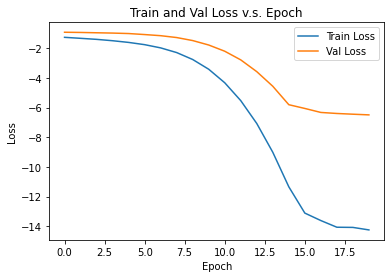

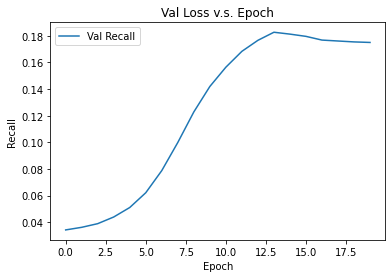

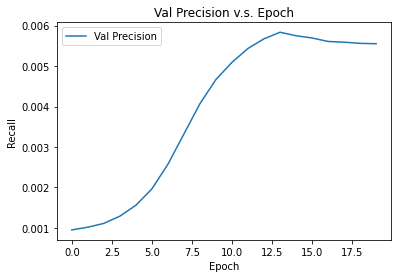

Training, Epoch: 1, Batch: 0/6, Loss: -0.9819703102111816
Epoch 1/20 Complete, Loss: -0.9888070722421011
Validating, Epoch: 1, Loss: -0.7796992460886637, Recall: 0.0353435149725446, Precision: 0.0009688486662139377
Training, Epoch: 2, Batch: 0/6, Loss: -0.9975932836532593
Epoch 2/20 Complete, Loss: -1.019372781117757
Validating, Epoch: 2, Loss: -0.7868500219451057, Recall: 0.03759285747242886, Precision: 0.0010486714872354264
Training, Epoch: 3, Batch: 0/6, Loss: -1.0345149040222168
Epoch 3/20 Complete, Loss: -1.048661430676778
Validating, Epoch: 3, Loss: -0.7966473897298177, Recall: 0.04071886679278134, Precision: 0.0011609903039329042
Training, Epoch: 4, Batch: 0/6, Loss: -1.0629819631576538
Epoch 4/20 Complete, Loss: -1.0860025882720947
Validating, Epoch: 4, Loss: -0.8060225248336792, Recall: 0.0462095695104481, Precision: 0.0013716869574385271
Training, Epoch: 5, Batch: 0/6, Loss: -1.1132696866989136
Epoch 5/20 Complete, Loss: -1.137855549653371
Validating, Epoch: 5, Loss: -0.82290

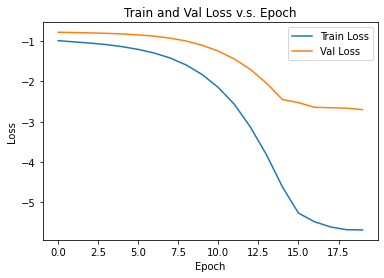

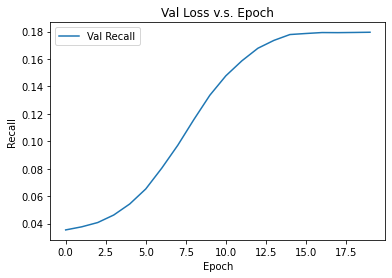

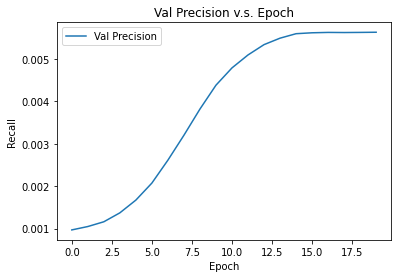

Best Recall: 0.1826350759009054 with hparams: {'embedding_dim': 64, 'num_layers': 2, 'batch_size': 1024} at epoch 13


In [27]:
best_model, best_hparams, best_recall, best_epoch = run_hparam_search(all_hparams, train_data, val_data, test_data)
print(f'Best Recall: {best_recall} with hparams: {best_hparams} at epoch {best_epoch}')

In [28]:
# calculate precision and recall on test set
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
test_loss, test_recall, test_precision = evaluate(
    best_model,
    test_loader,
    test_data,
    0,
    K=350,
)
print(f'Test Recall: {test_recall}, Test Precision: {test_precision}')

Validating, Epoch: 1, Loss: -6.433046685324775, Recall: 0.17652147833711881, Precision: 0.005512289814185267
Test Recall: 0.17652147833711881, Test Precision: 0.005512289814185267
